In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Volatility Forecasting

## Explaining stock returns' volatility with ARCH models

### How to do it...

1. Import the libraries:

In [1]:
# pip install --upgrade pip
# pip install yfinance --use-feature=2020-resolver
# pip install arch

In [3]:
import pandas as pd
import yfinance as yf
from arch import arch_model

2. Specify the risky asset and the time horizon:

In [4]:
RISKY_ASSET = 'GOOG'
START_DATE = '2015-01-01'
END_DATE = '2018-12-31'

3. Download data from Yahoo Finance:

In [5]:
df = yf.download(RISKY_ASSET,
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True)

print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 completed
Downloaded 1006 rows of data.


4. Calculate daily returns:

Average return: 0.08%


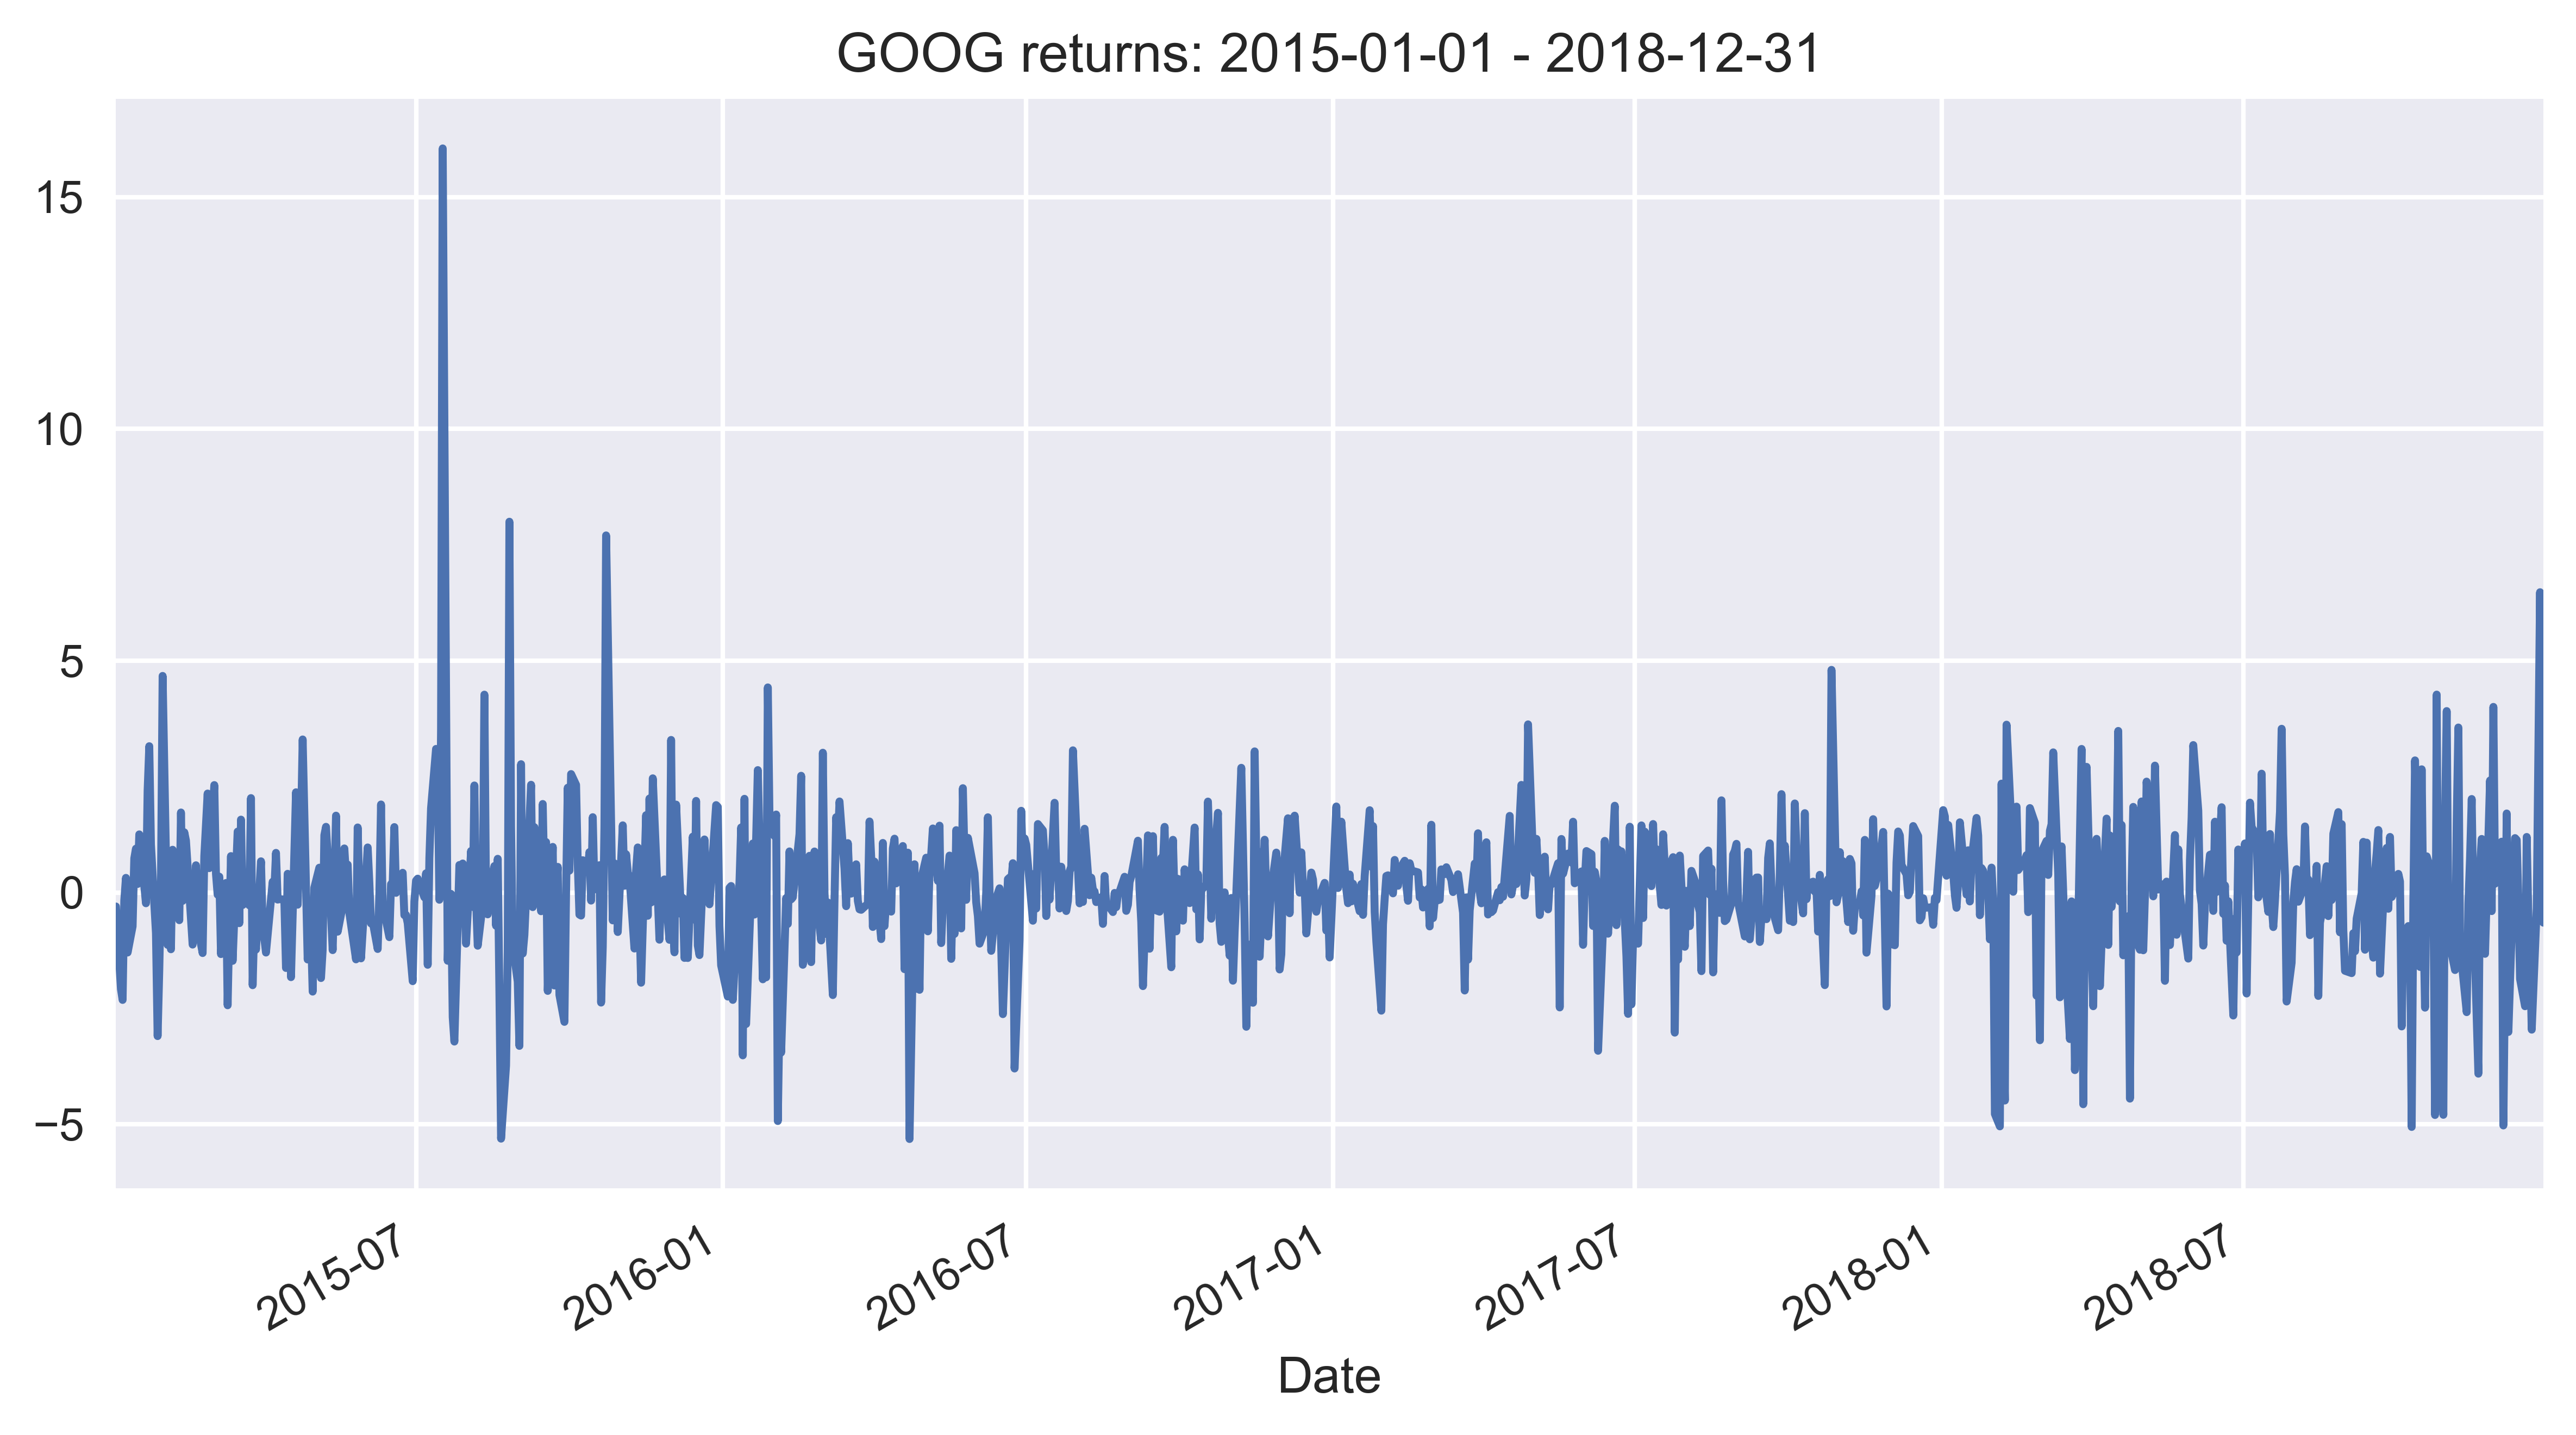

In [6]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.name = 'asset_returns'
print(f'Average return: {round(returns.mean(), 2)}%')
returns.plot(title=f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}');

plt.tight_layout()
# plt.savefig('images/ch5_im1.png')
plt.show()

5. Specify the ARCH model:

In [7]:
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)

6. Estimate the model and print the summary:

In [8]:
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -1800.60
Distribution:                  Normal   AIC:                           3605.19
Method:            Maximum Likelihood   BIC:                           3615.02
                                        No. Observations:                 1005
Date:                Thu, Oct 22 2020   Df Residuals:                     1003
Time:                        10:19:35   Df Model:                            2
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.6323      0.167      9.794  1.193e-22   [  1.30

7. Plot the residuals and the conditional volatility:

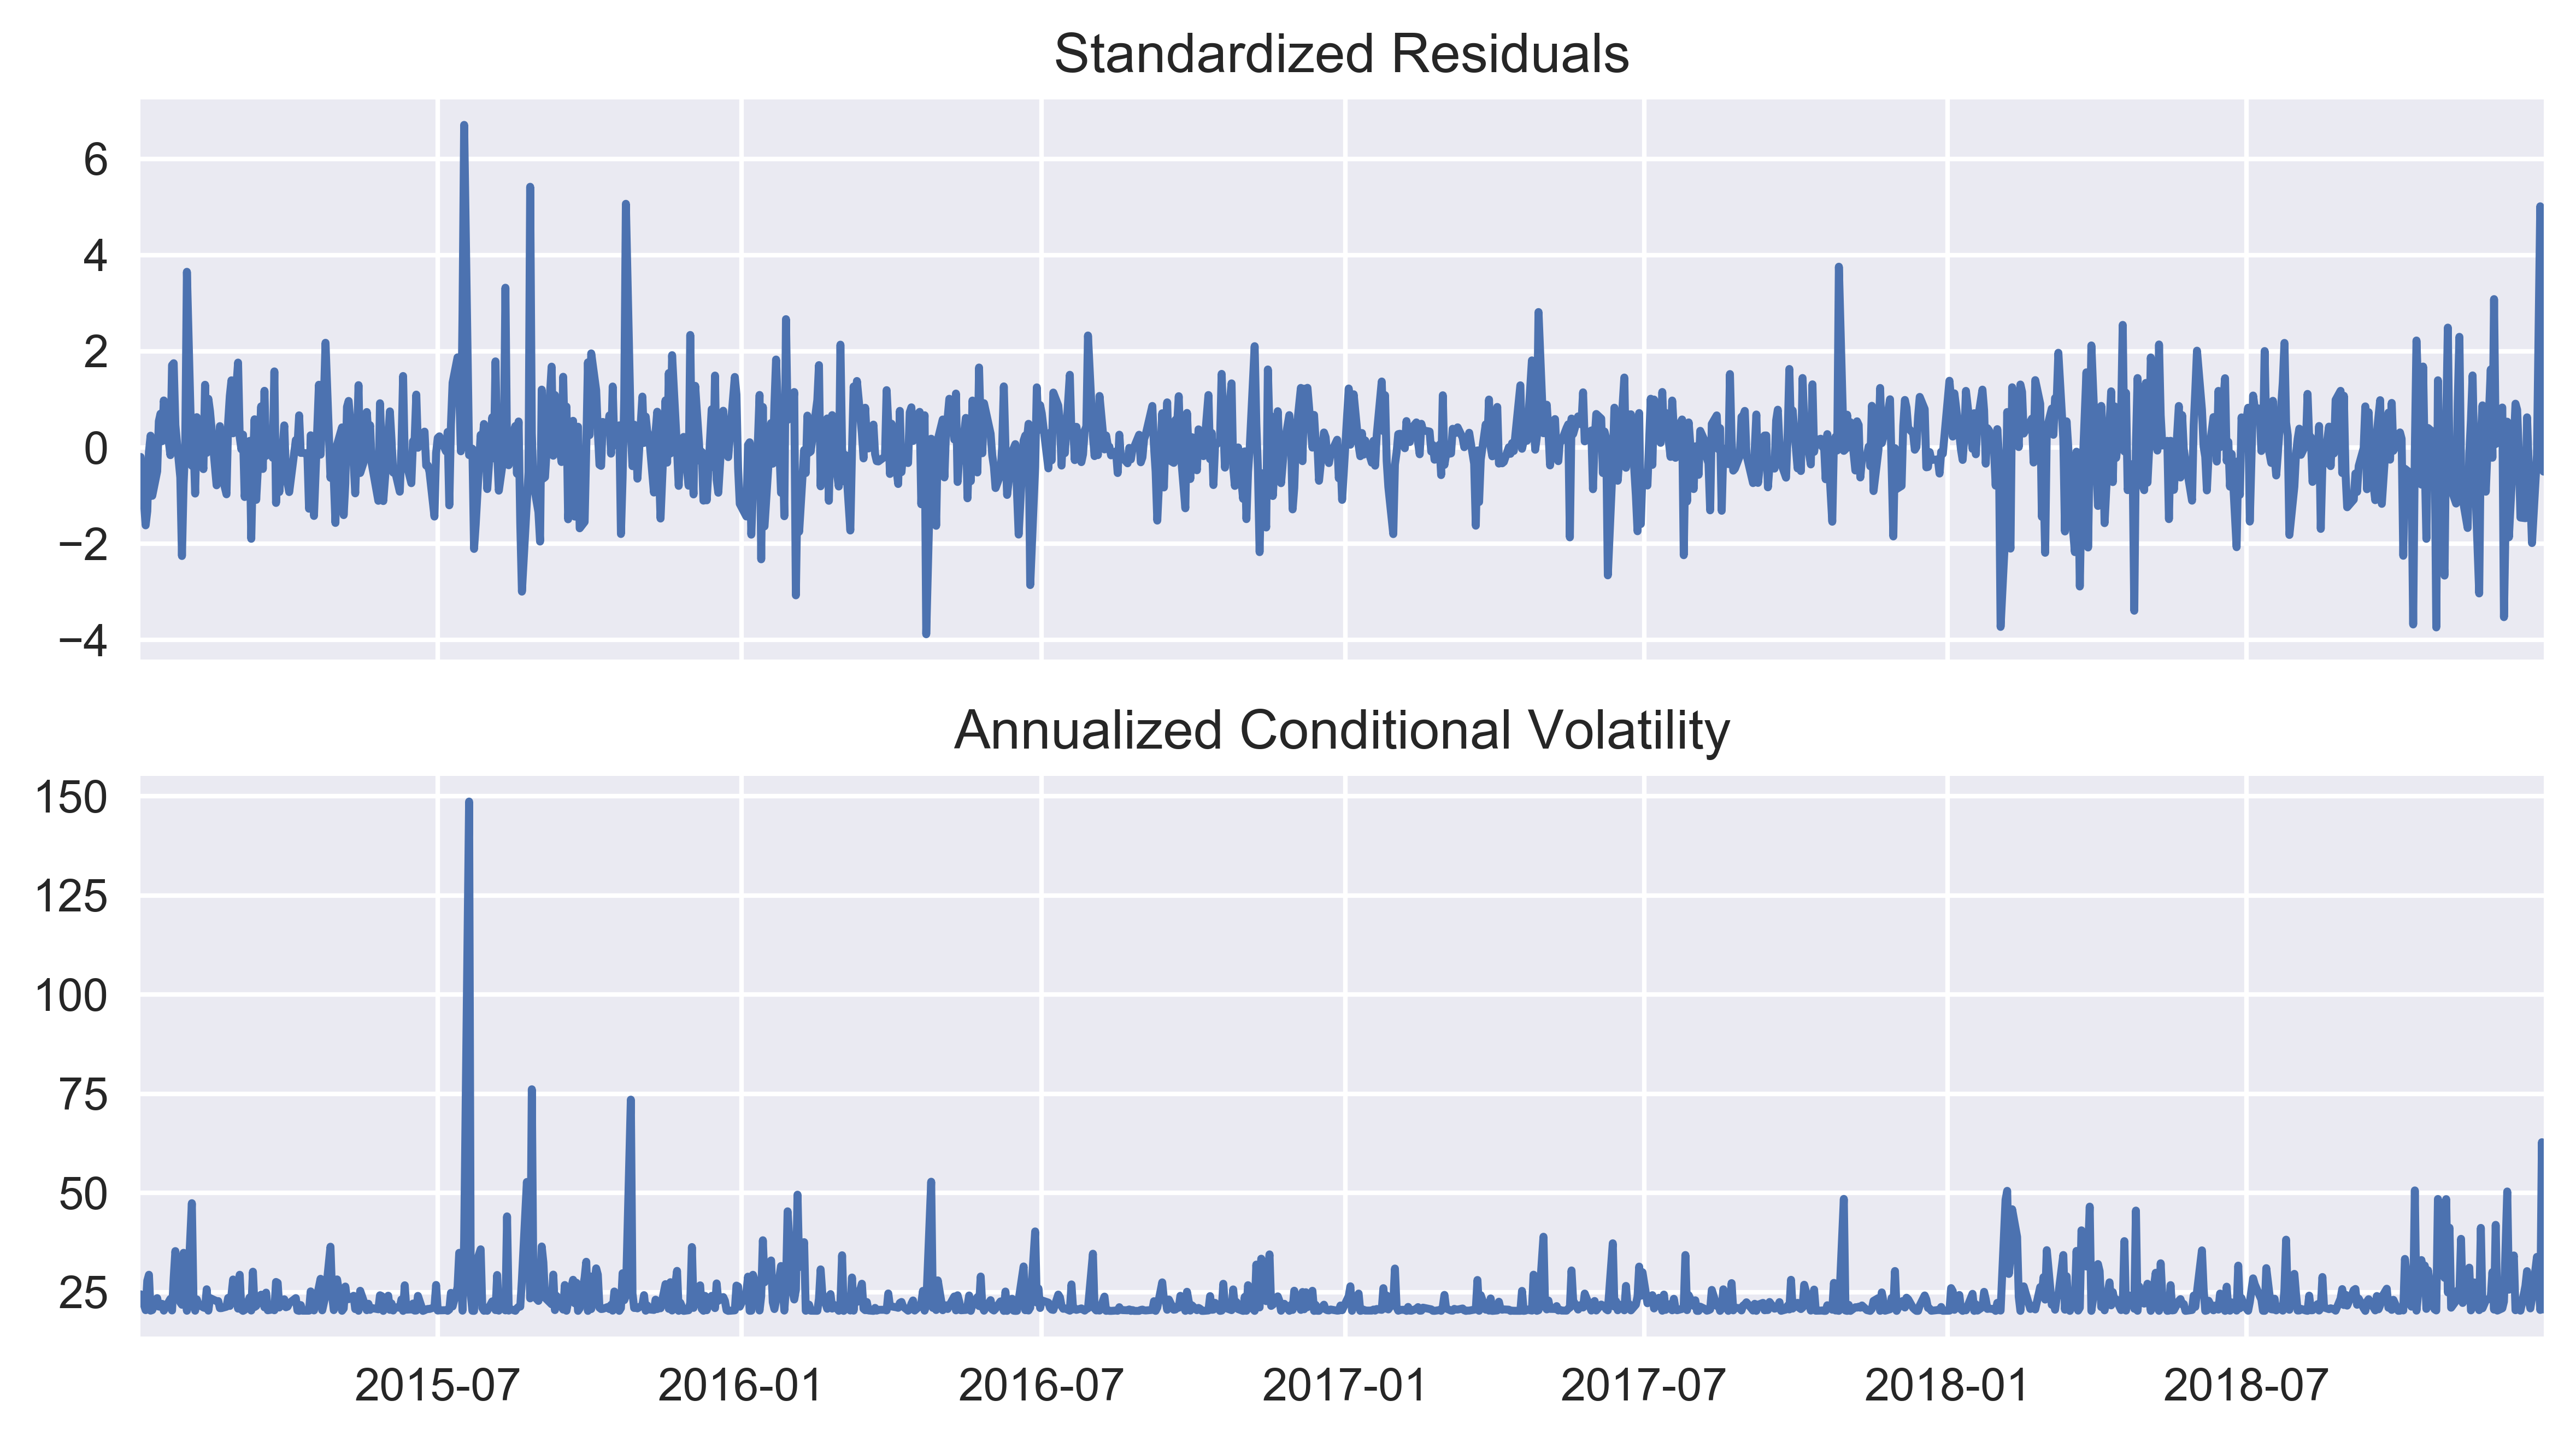

In [9]:
model_fitted.plot(annualize='D')

plt.tight_layout()
# plt.savefig('images/ch5_im3.png')
plt.show()

## Explaining stock returns' volatility with GARCH models

### How to do it...

1. Specify the GARCH model:

In [10]:
model = arch_model(returns, mean='Zero', vol='GARCH', 
                   p=1, o=0, q=1)

2. Estimate the model and print the summary:

In [11]:
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1764.88
Distribution:                  Normal   AIC:                           3535.75
Method:            Maximum Likelihood   BIC:                           3550.49
                                        No. Observations:                 1005
Date:                Thu, Oct 22 2020   Df Residuals:                     1002
Time:                        10:19:54   Df Model:                            3
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1781      0.157      1.134      0.257    [ -

3. Plot the residuals and the conditional volatility:

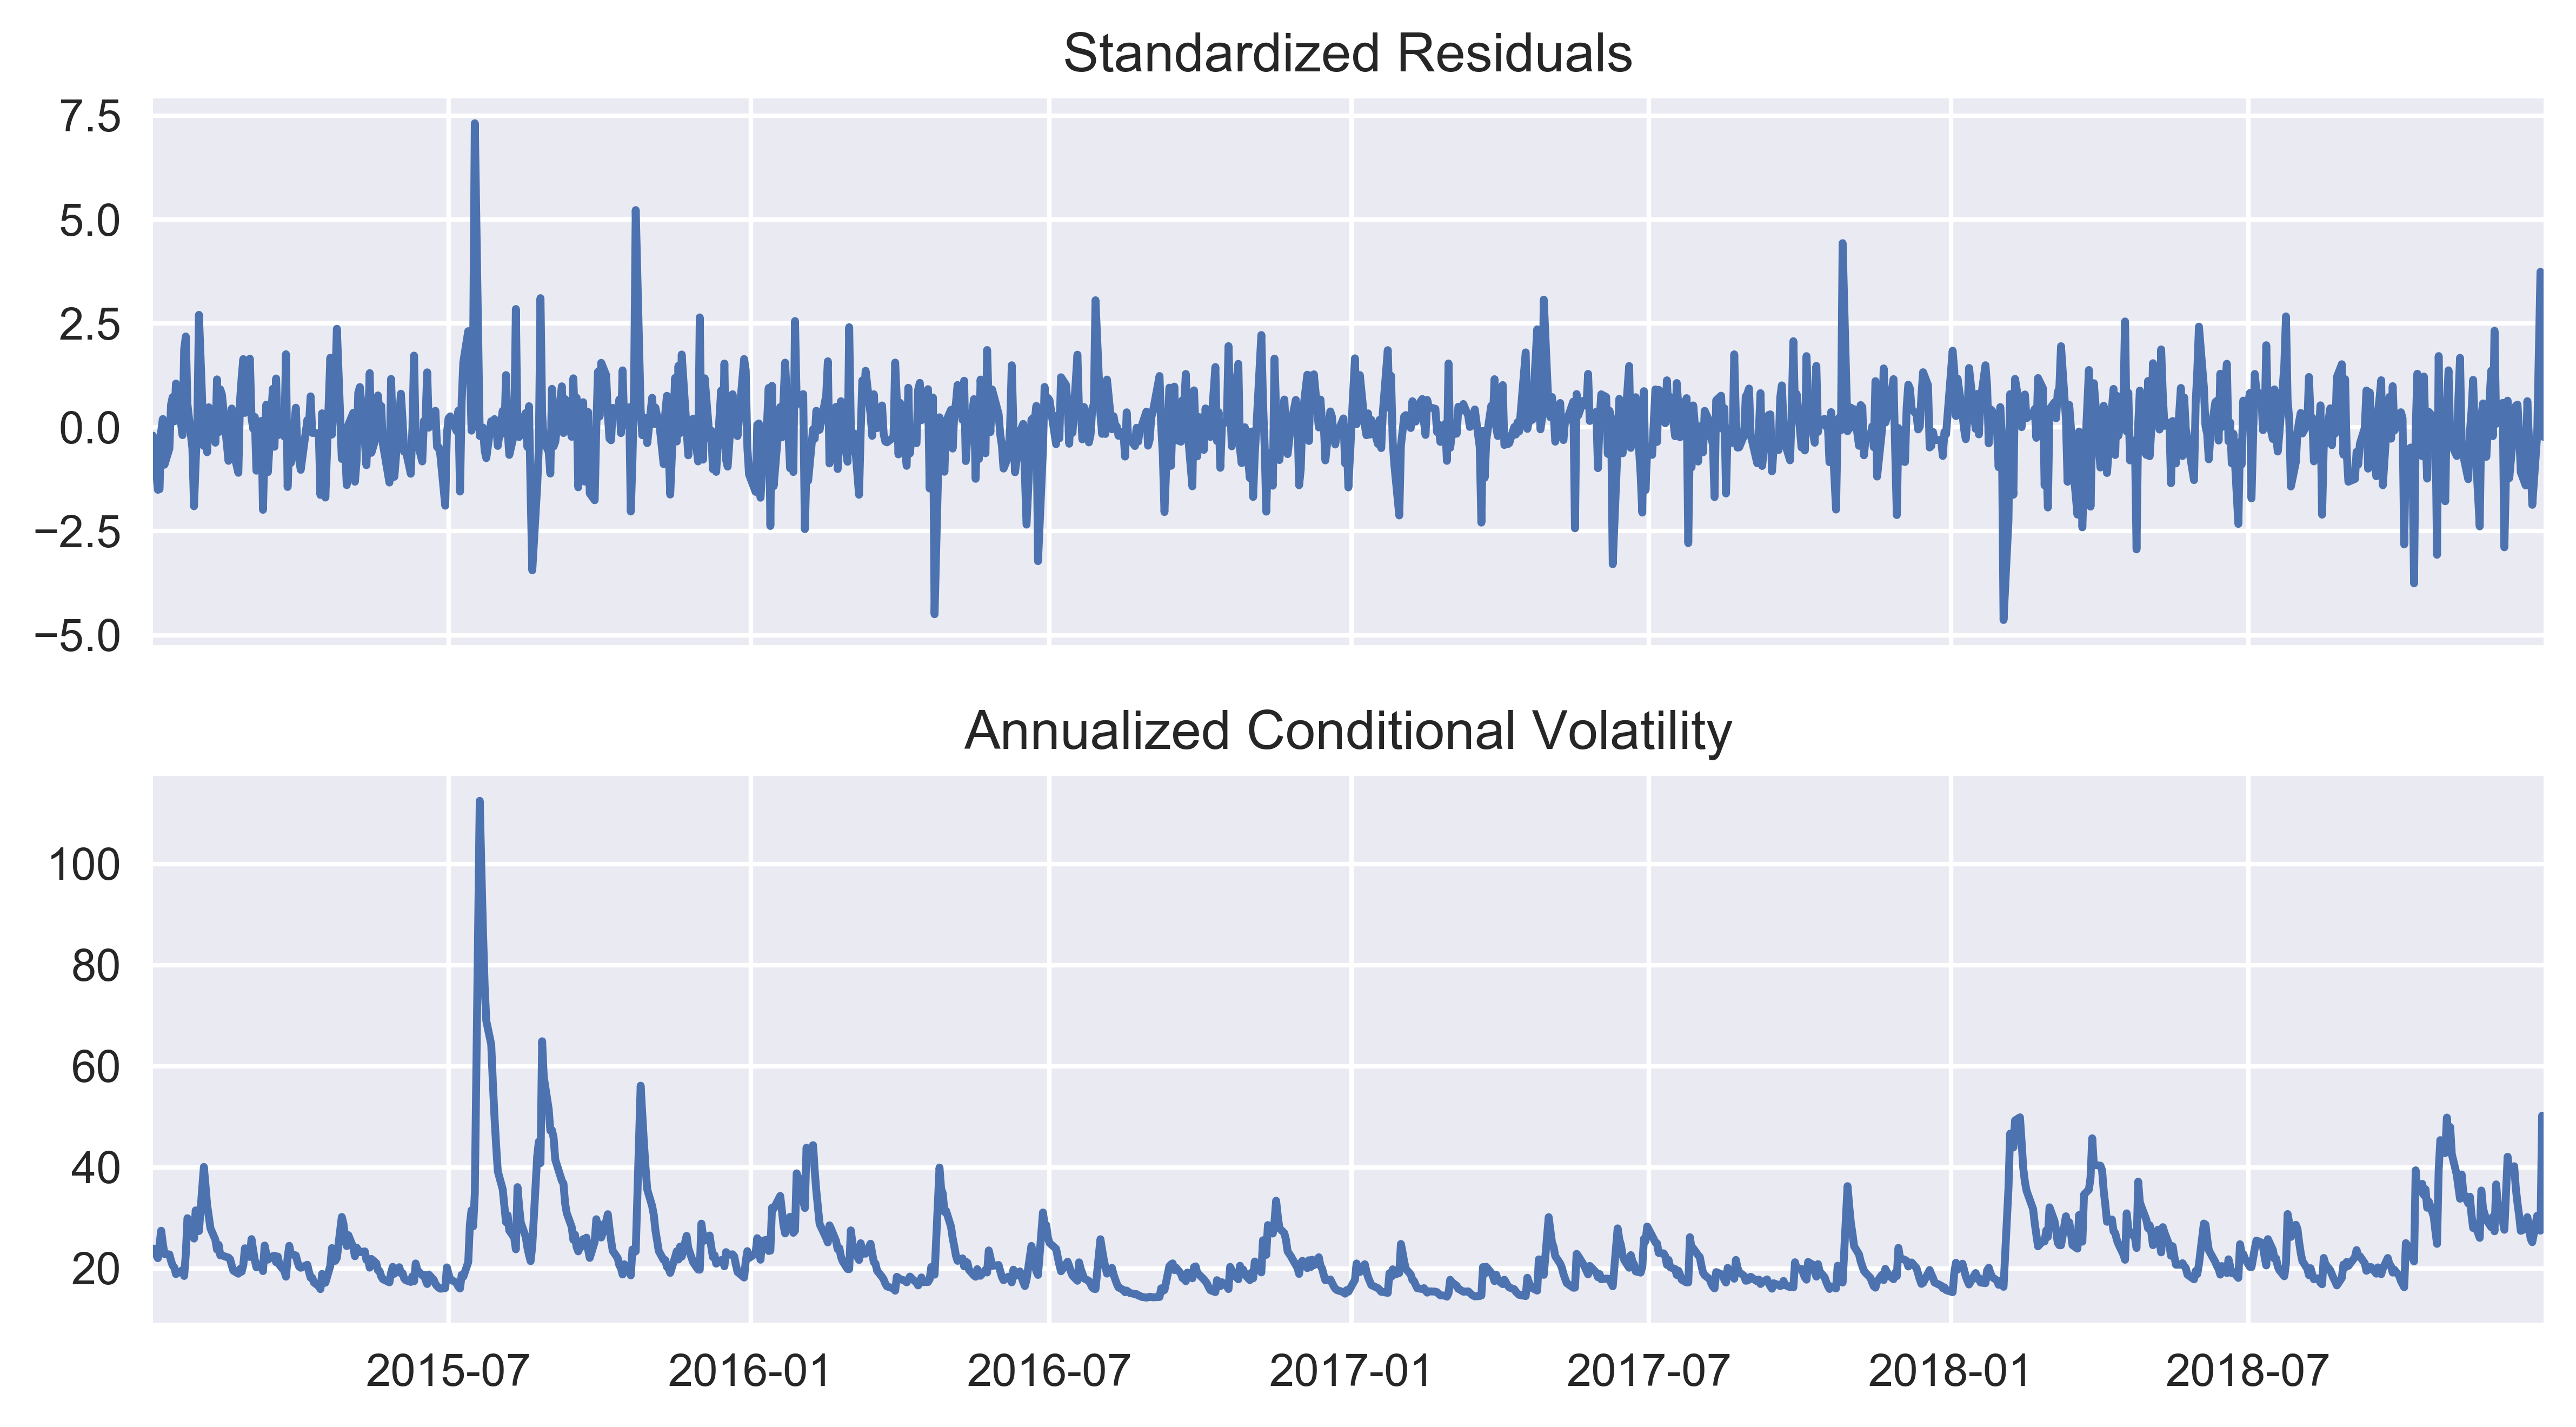

In [12]:
model_fitted.plot(annualize='D')

plt.tight_layout()
# plt.savefig('images/ch5_im5.png')
plt.show()

## Implementing CCC-GARCH model for multivariate volatility forecasting

### How to do it...

1. Import the libraries:

In [7]:
import pandas as pd
import yfinance as yf
from arch import arch_model

2. Specify the risky asset and the time horizon:

In [13]:
RISKY_ASSETS = ['GOOG', 'MSFT', 'AAPL']
N = len(RISKY_ASSETS)
START_DATE = '2015-01-01'
END_DATE = '2018-12-31'

3. Download data from Yahoo Finance:

In [14]:
df = yf.download(RISKY_ASSETS,
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True)

print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 1006 rows of data.


4. Calculate daily returns:

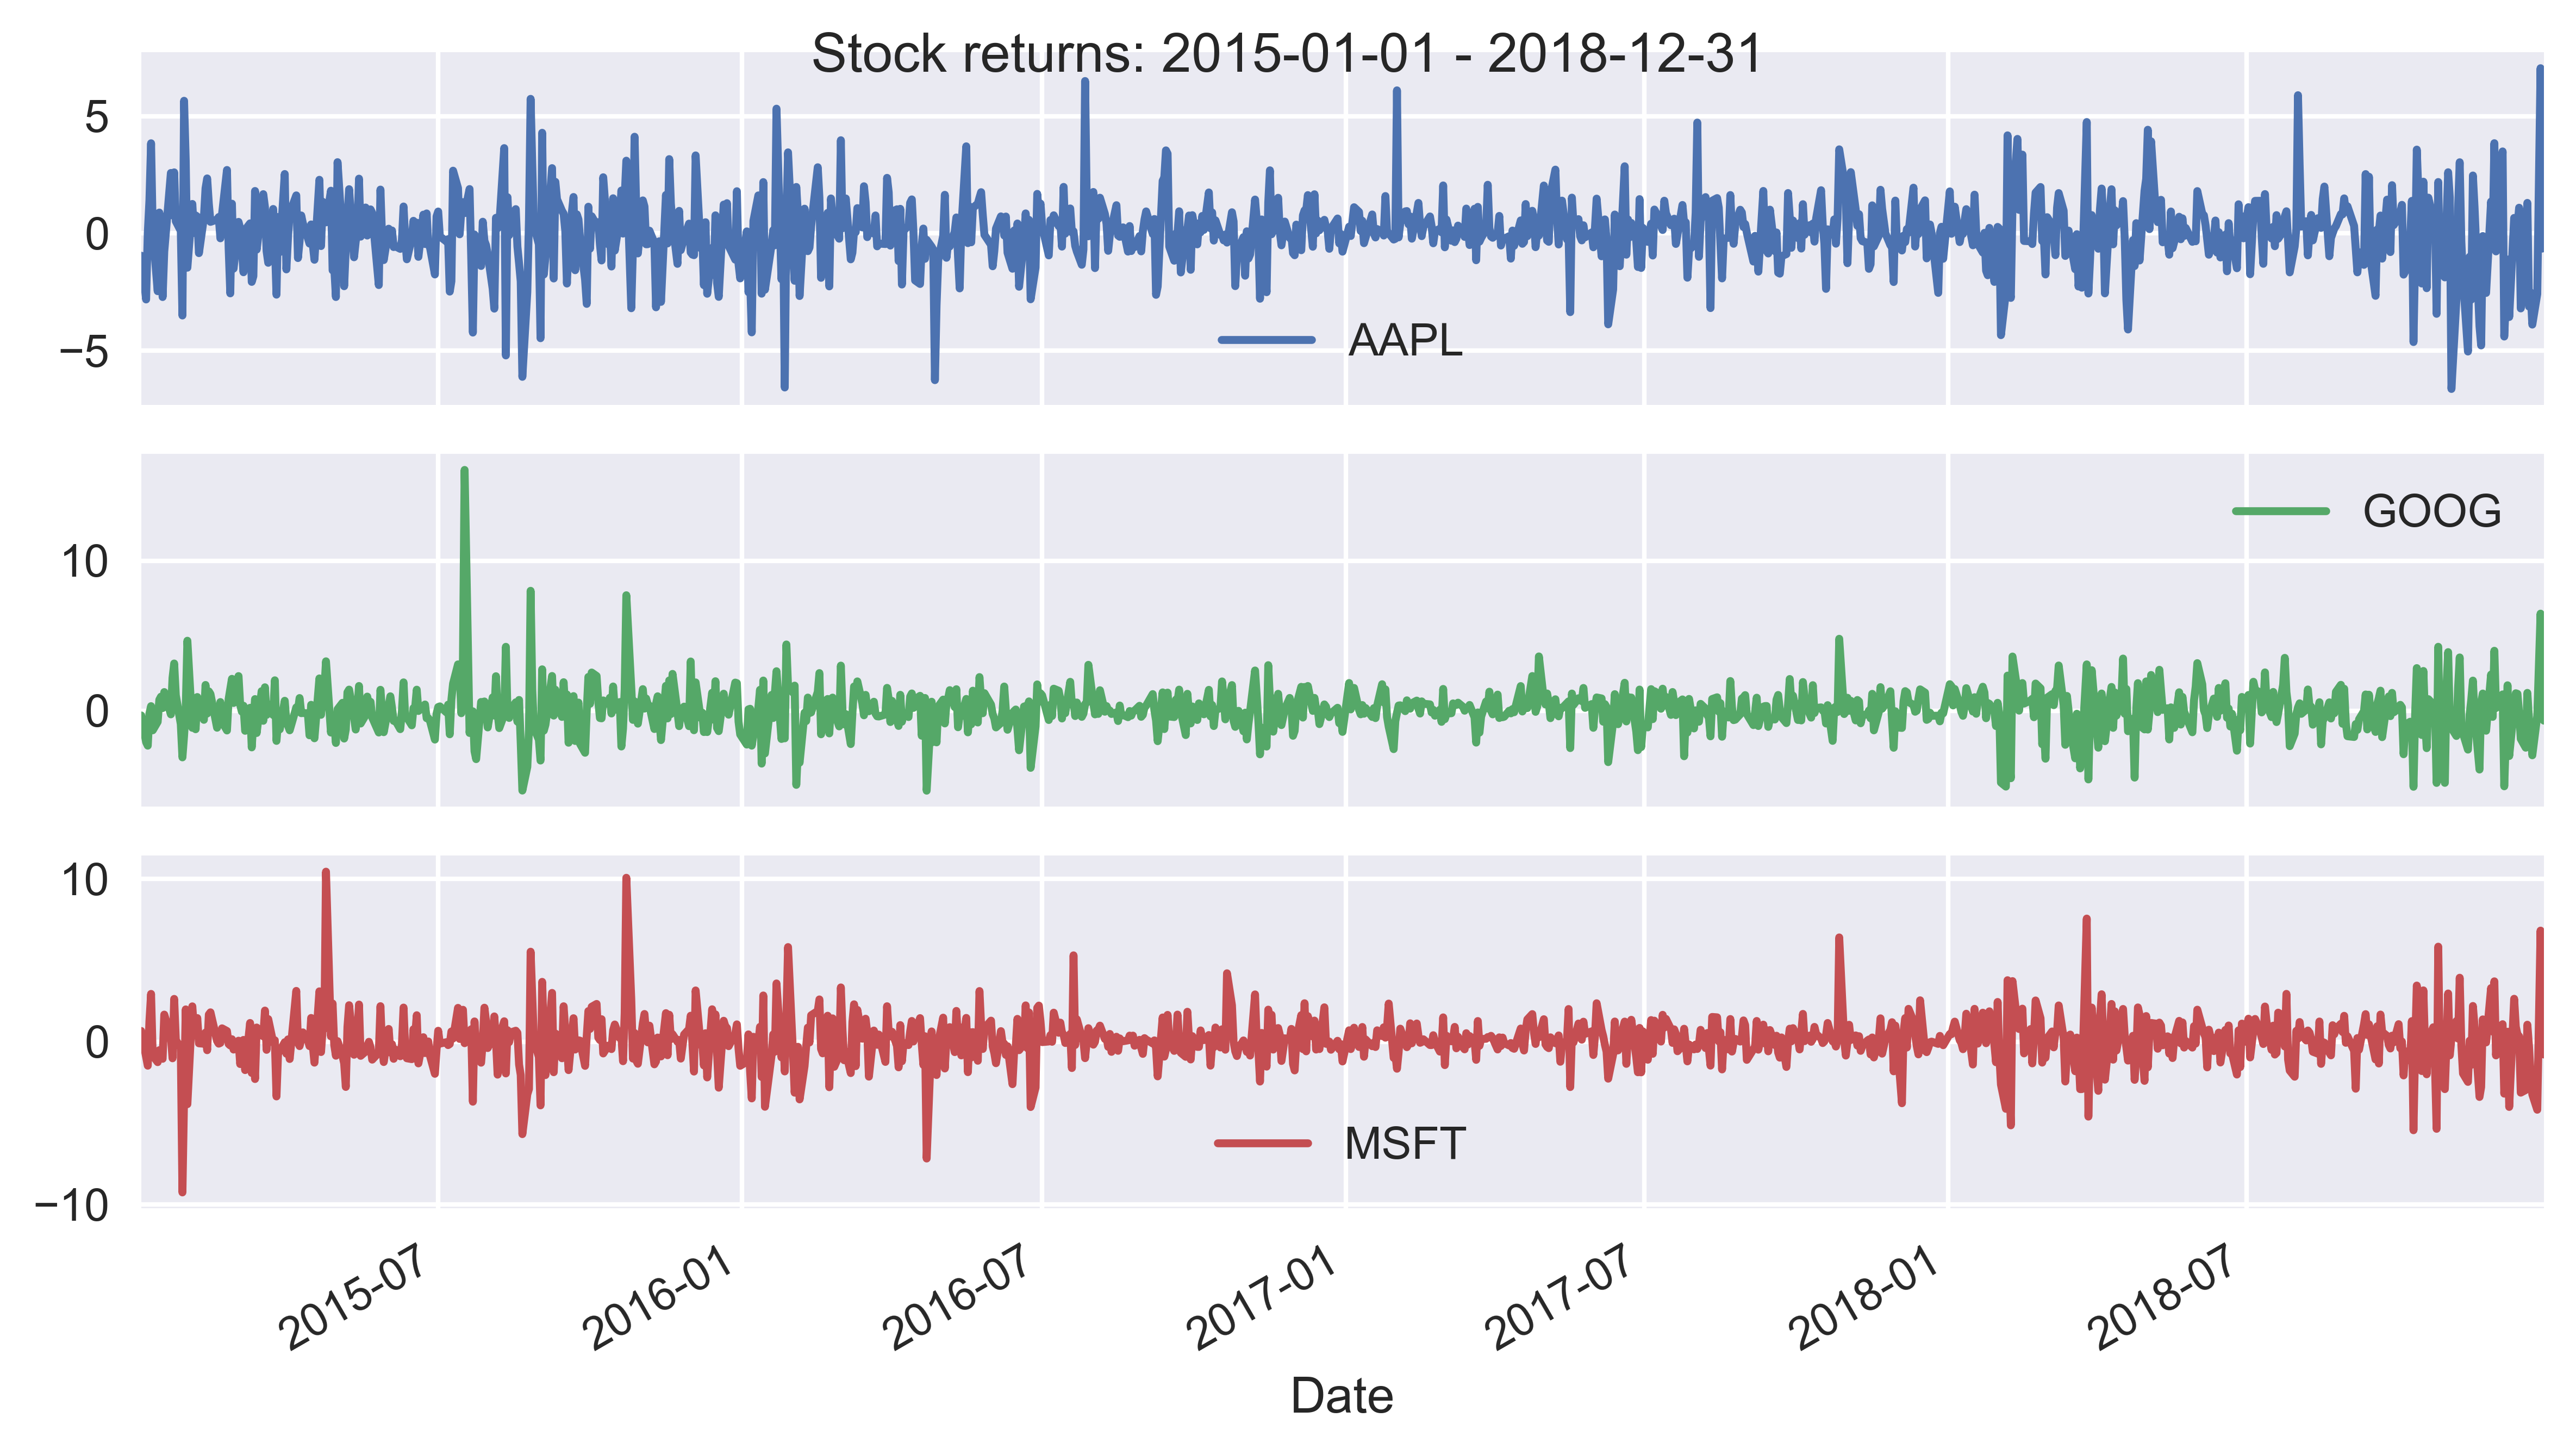

In [15]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.plot(subplots=True, 
             title=f'Stock returns: {START_DATE} - {END_DATE}')

plt.tight_layout()
# plt.savefig('images/ch5_im6.png')
plt.show()

5. Define lists for storing objects:

In [16]:
coeffs = []
cond_vol = []
std_resids = []
models = []

6. Estimate the univariate GARCH models:

In [17]:
for asset in returns.columns:
    # specify and fit the model
    model = arch_model(returns[asset], mean='Constant', 
                       vol='GARCH', p=1, o=0, q=1).fit(update_freq=0, 
                                                       disp='off');
    # store results in the lists 
    coeffs.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_resids.append(model.resid / model.conditional_volatility)
    models.append(model)

7. Store the results in DataFrames:

In [18]:
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
cond_vol_df = pd.DataFrame(cond_vol).transpose() \
                                    .set_axis(returns.columns, 
                                              axis='columns', 
                                              inplace=False)
std_resids_df = pd.DataFrame(std_resids).transpose() \
                                        .set_axis(returns.columns, 
                                                  axis='columns', 
                                                  inplace=False)

In [19]:
coeffs_df

,mu,omega,alpha[1],beta[1]
AAPL,0.123494,0.221224,0.125915,0.784531
GOOG,0.080485,0.193127,0.187875,0.747864
MSFT,0.119526,0.384324,0.251946,0.625822


8. Calculate the constant conditional correlation matrix (R):

In [20]:
R = std_resids_df.transpose() \
                 .dot(std_resids_df) \
                 .div(len(std_resids_df))

9. Calculate the 1-step ahead forecast of the conditional covariance matrix :

In [21]:
# define objects
diag = []
D = np.zeros((N, N))

# populate the list with conditional variances
for model in models:
    diag.append(model.forecast(horizon=1).variance.values[-1][0])
# take the square root to obtain volatility from variance
diag = np.sqrt(np.array(diag))
# fill the diagonal of D with values from diag
np.fill_diagonal(D, diag)

# calculate the conditional covariance matrix
H = np.matmul(np.matmul(D, R.values), D)

In [22]:
H

array([[6.98988142, 3.26916363, 3.73946389],
       [3.26916363, 6.15809531, 4.47491504],
       [3.73946389, 4.47491504, 7.51956725]])

## Forecasting the conditional covariance matrix using DCC-GARCH

### How to do it...

1. Import the libraries:

In [23]:
import pandas as pd

In [24]:
#pip install rpy2
#returns = 100 * df['Adj Close'].pct_change().dropna()
returns.head()

,AAPL,GOOG,MSFT
Date,,,
2015-01-02,-0.951279,-0.302049,0.667410
2015-01-05,-2.817169,-2.084573,-0.919576
2015-01-06,0.009443,-2.317705,-1.467744
2015-01-07,1.402221,-0.171326,1.270526
2015-01-08,3.842234,0.315308,2.941811


In [25]:
%load_ext rpy2.ipython

2. Install `rmgarch` R package (run only once) and load it:

In [13]:
%%R
#setRepositories()
#install.packages('rmgarch', dependencies=TRUE, repos = "http://cran.us.r-project.org")
install.packages('rmgarch')
#library(rmgarch)

R[write to console]: Installing package into ‘/home/mir/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/rmgarch_1.3-7.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 974764 bytes (951 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to c

In [16]:
#%%R
#.libPaths()

[1] "/home/mir/R/x86_64-pc-linux-gnu-library/3.5"
[2] "/usr/local/lib/R/site-library"              
[3] "/usr/lib/R/site-library"                    
[4] "/usr/lib/R/library"                         


In [26]:
%%R
library(rmgarch)

R[write to console]: Loading required package: rugarch

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘rugarch’


R[write to console]: The following object is masked from ‘package:stats’:

    sigma




3. Import the dataset into R:

In [27]:
%%R -i returns
print(head(returns, 5))


                            AAPL       GOOG       MSFT
2015-01-02 00:00:00 -0.951279109 -0.3020489  0.6674097
2015-01-05 00:00:00 -2.817169387 -2.0845731 -0.9195763
2015-01-06 00:00:00  0.009442765 -2.3177049 -1.4677442
2015-01-07 00:00:00  1.402220508 -0.1713264  1.2705261
2015-01-08 00:00:00  3.842233845  0.3153082  2.9418111


4. Define the model specification:

In [28]:
%%R
n=3

In [29]:
%%R

# define GARCH(1,1) model
univariate_spec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                              variance.model = list(garchOrder = c(1,1), 
                                                    model = "sGARCH"),
                              distribution.model = "norm")

# define DCC(1,1) model
#n <-dim(returns)[2]
dcc_spec <- dccspec(uspec = multispec(replicate(n, univariate_spec)),
                    dccOrder = c(1,1),
                    distribution = "mvnorm")

dcc_spec


*------------------------------*
*       DCC GARCH Spec         *
*------------------------------*
Model          :  DCC(1,1)
Estimation     :  2-step
Distribution   :  mvnorm
No. Parameters :  17
No. Series     :  3



5. Estimate the model:

In [30]:
%%R
dcc_fit <- dccfit(dcc_spec, data=returns)
dcc_fit


*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(1,1)
No. Parameters       :  17
[VAR GARCH DCC UncQ] : [0+12+2+3]
No. Series           :  3
No. Obs.             :  1005
Log-Likelihood       :  -4889.896
Av.Log-Likelihood    :  -4.87 

Optimal Parameters
-----------------------------------
               Estimate  Std. Error  t value Pr(>|t|)
[AAPL].mu      0.123537    0.046510  2.65612 0.007904
[AAPL].omega   0.225569    0.088555  2.54723 0.010858
[AAPL].alpha1  0.128261    0.035272  3.63640 0.000276
[AAPL].beta1   0.780928    0.052638 14.83578 0.000000
[GOOG].mu      0.080477    0.042764  1.88190 0.059849
[GOOG].omega   0.193086    0.161143  1.19822 0.230830
[GOOG].alpha1  0.187837    0.126908  1.48011 0.138845
[GOOG].beta1   0.747908    0.154245  4.84884 0.000001
[MSFT].mu      0.122079    0.044244  2.75922 0.005794
[MSFT].omega   0.014935    0.088537  0.16869 0.86

6. Calculate the 5-step ahead forecasts:

In [31]:
%%R
forecasts <- dccforecast(dcc_fit, n.ahead = 5)

7. Access the forecasts:

In [32]:
%%R

# conditional covariance matrix
forecasts@mforecast$H
# conditional correlation matrix
forecasts@mforecast$R
# proxy correlation process
forecasts@mforecast$Q
# conditional mean forecasts
forecasts@mforecast$mu

, , 1

          [,1]       [,2]      [,3]
[1,] 0.1235374 0.08047722 0.1220793
[2,] 0.1235374 0.08047722 0.1220793
[3,] 0.1235374 0.08047722 0.1220793
[4,] 0.1235374 0.08047722 0.1220793
[5,] 0.1235374 0.08047722 0.1220793



### There's more

In [ ]:
%%R

# parallelized DCC-GARCH(1,1)

library('parallel')

# set up the cluster
cl <- makePSOCKcluster(3)

# define parallelizable specification
parallel_fit <- multifit(multispec(replicate(n, univariate_spec)), 
                         returns, 
                         cluster = cl)

# fit the DCC-GARCH model
dcc_fit <- dccfit(dcc_spec, 
                  data = returns, 
                  fit.control = list(eval.se = TRUE), 
                  fit = parallel_fit, 
                  cluster = cl)

# stop the cluster
stopCluster(cl)